In [1]:
import scipy.stats as stats
from scipy.integrate import quad
import scipy
import numpy as np
import pandas as pd
import time
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit

In [2]:
#load the parameters, and their short int feats?
labels = np.loadtxt("../../csvs/Res_feats/order.txt", dtype=str)
parameters = pd.read_csv("../../csvs/Res_feats/Weibull_Parameters_6.csv", index_col =0 )
#parameters.head(5)
parameters[parameters["Gamma"]<1][:10]
print parameters["Location"].max()
parameters["ID"] = labels
parameters

5.350923639668232


,ID,Gamma,Location,Alpha
0,res1.bin_1000.csv,0.952252,5.242694,0.059838
1,res2.bin_1000.csv,3.629805,4.181471,0.945919
2,res3.bin_1000.csv,2.126401,5.350924,1.161528
3,res4.bin_1000.csv,3.523820,4.204052,1.958811
4,res5.bin_1000.csv,1.958719,4.547164,0.761134
5,res6.bin_1000.csv,1.906946,4.337552,0.778403
6,TwoPlanets1.bin_1000.csv,2.496427,4.111580,2.228231
7,TwoPlanets2.bin_1000.csv,2.716537,3.952396,1.679034
8,TwoPlanets3.bin_1000.csv,1.244287,3.823293,0.829197


#do a check how manysytems are valid, as we are only considering systems with an instability time range between 10^4 to ~10^6 (<\10^7), but there are some with lower time scales

In [3]:
#need to do a double integral

def weib(loc, loc_fixed, gamma, alpha, x):
    #assume x is log t
    prob = (gamma/alpha)* ((loc-loc_fixed)/alpha)**(gamma-1.) * np.exp(-((loc-loc_fixed)/alpha)**gamma)
    dist = (gamma/alpha)* ((x-loc)/alpha)**(gamma-1.) * np.exp(-((x-loc)/alpha)**gamma)
    return prob*dist

In [4]:
#need to do a double integral
#x must be an ARRAY
def weib_pdf(x, loc,  gamma, alpha):
    #assume x is log t
    problematic = np.where(x<loc)[0]
    #print problematic
    fine = np.where(x>loc)[0]
    #print fine
    prob = np.zeros_like(x)
    #print x[fine]
    #includes normalization constants
    prob[fine] = (gamma/alpha)* ((x[fine]-loc)/alpha)**(gamma-1.) * np.exp(-((x[fine]-loc)/alpha)**gamma)
    #print prob[fine]
    prob[problematic]=0.
    #width = np.abs(x[0] - x[1])
    #prob = prob/(np.sum(prob)*width)
    return prob

In [5]:
#need to do a double integral
#x can be int or aray, but has poor error handling
def weib_pdf_val(x, loc,  gamma, alpha):
    #assume x is log t  
    prob = (gamma/alpha)* ((x-loc)/alpha)**(gamma-1.) * np.exp(-((x-loc)/alpha)**gamma)
    #print prob[fine]
    return prob

In [6]:
#2.61402658322 1.28337089098 4.44752697372
gamma = 2.61402658322
alpha = 1.28337089098
loc = 4.44752697372
x = 4.5
(gamma/alpha)* ((x-loc)/alpha)**(gamma-1.) * np.exp(-((x-loc)/alpha)**gamma)

0.011692716127467438

In [7]:
# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

2.1264012845100515 1.1615280624146402 5.350923639668232 597270.3544544773


/home/naireen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


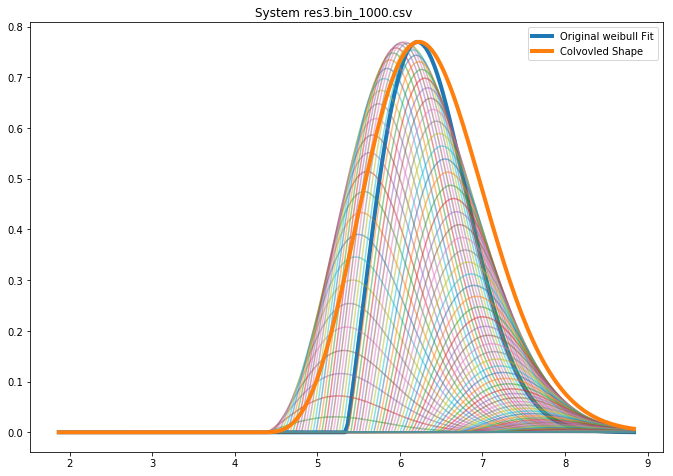

In [8]:
index_val = 2
#print 
label = parameters["ID"][index_val]
#print label
gamma = parameters["Gamma"][index_val]
alpha = parameters["Alpha"][index_val]
loc = parameters["Location"][index_val]
x = pd.read_csv("../../csvs/Res_feats/{}".format(parameters["ID"][index_val]))["t"][0]

print gamma, alpha, loc, x 
from scipy.stats import norm
fig, ax = plt.subplots(1)
fig.tight_layout()
fig.set_size_inches((10, 7))
fig.suptitle("System {0}".format((label)))

fig.subplots_adjust(hspace=0)
width = 200

sigma_width = 3
vals= np.linspace(loc- sigma_width*alpha, loc+alpha*sigma_width, width)
#vals = vals[vals]
vals =  vals [vals >0]
#print vals
#break
final_y  = np.zeros(vals.shape[0])
ax.plot(vals, weib_pdf(vals, loc,gamma, alpha), linewidth = 4, label = "Original weibull Fit")
max_val =  weib_pdf(vals, loc,gamma, alpha).max()
for i in range(int(vals.shape[0])):
    
    #try manually adding three different functions
    bins = np.linspace(loc - sigma_width*alpha , loc+sigma_width*alpha, width)
    bins = bins[bins>0]
    val1 = vals[i]
    exp_val = alpha*scipy.special.gamma(1+ 1./gamma)
    prob = weib_pdf_val(val1, loc-exp_val, gamma, alpha) 
    
    y_normal = weib_pdf(bins, val1, gamma, alpha)
    #fair to say that new distribtions shouldn't be more likely than the real distribution  
    y = prob*weib_pdf(bins, val1,gamma, alpha) / max_val

    ax.plot(bins, y, alpha = 0.5)
    final_y = np.nansum(np.asarray([y, final_y]), axis = 0) 
    
#original weibul shape?    #overlap with the convoltions?
final_y =  final_y / (final_y.max() / weib_pdf(bins, loc,gamma, alpha).max())
ax.plot(bins, final_y, linewidth = 4, label = "Colvovled Shape")
#ax3.set_xlabel("Log Time")


#plot cdf of original distribution
#plt.figure(figsize=(8, 4))
#cumul_y = np.cumsum(final_y)
#cumul_w = np.cumsum(weib_pdf(bins, loc,gamma, alpha))
#plt.plot(bins, cumul_y/cumul_y[-1], label = "Gaussian Fit")
#plt.plot(bins, cumul_w/cumul_w[-1], label = "Original Weibull Distribution")
plt.legend()

[0.77455305 6.30599751 0.72157161]
0.6985046762538026
0.7003261754845573


0.9610725092770799

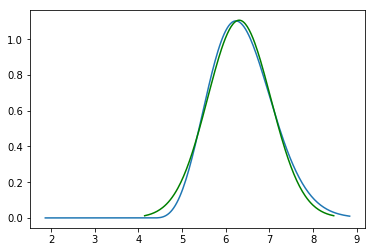

In [9]:
p0 = [1., loc+alpha*sigma_width, alpha] #norm, mean, sigma
coeff, var_matrix = scipy.optimize.curve_fit(gauss, bins, final_y, p0=p0)
# Get the fitted curve
gauss_bins = np.linspace(loc-5*sigma_width , loc+7*sigma_width, width)

print coeff


hist_fit = gauss(bins, *coeff)
hist_fit2 = gauss(gauss_bins, *coeff)
#incrementing step
delta_t = (( loc+sigma_width*alpha) -loc)/(width-1)

summed_fit_area_weib = 0
for val in final_y:
    summed_fit_area_weib+=  val*delta_t 
print summed_fit_area_weib

summed_fit_area_gauss = 0
for val in hist_fit:
    summed_fit_area_gauss+=  val*delta_t 
print summed_fit_area_gauss

#plot normalized curves for visual inspection
plt.plot(bins, final_y/summed_fit_area_weib)
test_bins = np.linspace(coeff[1] - sigma_width*coeff[2], coeff[1] + sigma_width*coeff[2], width)
plt.plot(test_bins, gauss(test_bins, *coeff)/summed_fit_area_gauss, color = "green")
overlapp = np.concatenate([(final_y/summed_fit_area_weib).reshape(width,1), 
                           (hist_fit/summed_fit_area_gauss).reshape(width, 1)], axis = 1)
overlapp.min(axis = 1).sum()*delta_t

Try doing this for all 145 systems

In [15]:
start = time.time()
info = np.zeros((parameters.shape[0], 7), dtype=object) # add norm const, RMS
corrupted = []
for index_val in range(int(parameters.shape[0])):
    width = 150 #incremental step

    #fig = plt.figure(figsize=(15, 5))
    #ax = fig.add_subplot("121")
    #ax2 = fig.add_subplot("122")
    #print index_val, 
    label = parameters["ID"][index_val]
    #print label
    gamma = parameters["Gamma"][index_val]
    alpha = parameters["Alpha"][index_val]
    loc = parameters["Location"][index_val]
    x = pd.read_csv("../../csvs/Res_feats/{}".format(parameters["ID"][index_val]))["t"][0]

    print gamma, alpha, loc, x 
    from scipy.stats import norm
    fig, ax = plt.subplots(1)
    fig.tight_layout()
    fig.set_size_inches((10, 7))
    fig.suptitle("System {0}".format((label)))

    fig.subplots_adjust(hspace=0)
    width = 200

    sigma_width = 4
    vals= np.linspace(loc- sigma_width*alpha, loc+alpha*sigma_width, width)

    if vals.max() - vals.min() < 1:
        sigma_width = 6
        vals= np.linspace(loc- sigma_width*alpha, loc+alpha*sigma_width, width)

    #vals = vals[vals]
    vals =  vals [vals >0]
    #print vals
    #break
    final_y  = np.zeros(vals.shape[0])
    ax.plot(bins, weib_pdf(bins, loc,gamma, alpha), linewidth = 4, label = "Original weibull Fit")
    max_val =  weib_pdf(bins, loc,gamma, alpha).max()
    for i in range(int(vals.shape[0])):

        #try manually adding three different functions
        bins = vals[:]
        #bins = bins[bins>0]
        val1 = vals[i]
        exp_val = alpha*scipy.special.gamma(1+ 1./gamma)
        prob = weib_pdf_val(val1, loc-exp_val, gamma, alpha) 

        y_normal = weib_pdf(bins, val1, gamma, alpha)
        #fair to say that new distribtions shouldn't be more likely than the real distribution  
        y = prob*weib_pdf(bins, val1,gamma, alpha) / max_val

        ax.plot(bins, y, alpha = 0.5)
        final_y = np.nansum(np.asarray([y, final_y]), axis = 0) 
    
    #original weibul shape?    #overlap with the convoltions?
    final_y =  final_y / (final_y.max() / weib_pdf(bins, loc,gamma, alpha).max())
    ax.plot(bins, final_y, linewidth = 4, label = "Colvovled Shape")
    #ax2.plot(bins, final_y)    
    p0 = [1., loc+alpha*scipy.special.gamma(1+ 1./gamma), alpha] #norm, mean, sigma
    #popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])
    try:
    
        coeff, var_matrix = scipy.optimize.curve_fit(gauss, bins, final_y, p0=p0)
        #print var_matrix
        perr = np.sqrt(np.diag(var_matrix))
        plt_title = 'Convolution Parameters For System {4}: Mean: {0:.5} E {2:.4}   Sigma: {1:.5} E: {3:.4}'.format(coeff[1], np.abs(coeff[2]), perr[1], perr[2], label)
        #print "Coefs: Mean, Sigma", coeff[1:], "Error", perr[1:]
        #fit can cbe calculated
        delta_t = (( loc+sigma_width*alpha) -loc - 0.0001)/(width-1)
        summed_fit_area_weib=0
        summed_fit_area_gauss = 0


        ###########################Error calcualtion###############################

        # Get the fitted curve
        hist_fit = gauss(bins, *coeff)


        #find the total sum of final_y to find normalizing constant
        summed_fit_area_weib = np.sum(final_y)*delta_t
        summed_fit_area_gauss = np.sum(hist_fit)*delta_t


        overlapp = np.concatenate([(final_y/summed_fit_area_weib).reshape(vals.shape[0],1), 
                                   (hist_fit/summed_fit_area_gauss).reshape(vals.shape[0], 1)], axis = 1)
        #define IOU as the sum, of their overlap, so take the min of both and sum it multiplied by delta t 
        IOU = overlapp.min(axis = 1).sum()*delta_t
        #overlapped area
        print IOU, label

        ###########################################################################   
        info[index_val] = [label, coeff[0], coeff[1], perr[1], coeff[2], perr[2], IOU]

    except Exception as e:
        print e
        info[index_val] = [label,np.inf, np.inf, np.inf, np.inf, np.inf, np.inf]
        print info[index_val]
        plt_title = 'Convolution Parameters For System {0}'.format(label)

    
    
    
    
    plt.suptitle(plt_title)
    #plt.show()
    #plt.savefig("../../Figures/ConvolutedFigures/{0}.png".format(sub_short.index[index_val]))
    plt.close()
    #print sub_short.index[index_val]
    #break
    #hist_fit = gauss(bins, *coeff)
    #plt.plot(bins, hist_fit/summed_fit_area_gauss)
    #plt.plot(bins, final_y/summed_fit_area_weib)
    #print info[index_val]
    #break
end = time.time()
print end-start


0.9522524849034316 0.059838059212130534 5.242694138973298 187128.96794760934


/home/naireen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


0.8280389008591514 res1.bin_1000.csv
3.629805082434821 0.9459187916821744 4.181471354690883 108979.1472636857
0.993748986184329 res2.bin_1000.csv
2.1264012845100515 1.1615280624146402 5.350923639668232 597270.3544544773
0.9605793440768645 res3.bin_1000.csv
3.5238199624704354 1.9588110937490304 4.204051972233423 197940.93010835085
0.9939239975813746 res4.bin_1000.csv
1.9587191495949383 0.7611340776463633 4.547163718171607 293981.14019779523
0.9521635580301614 res5.bin_1000.csv
1.906945979474804 0.7784028983811541 4.3375515298106935 195704.95010626843
0.9492451683583883 res6.bin_1000.csv
2.496426795837257 2.228231199288402 4.111580347689483 9298874.700780148
0.9749834395577357 TwoPlanets1.bin_1000.csv
2.7165370152104185 1.6790343458432018 3.952395732525096 350501.46663341107
0.9816196558998652 TwoPlanets2.bin_1000.csv
1.244287064930537 0.8291967163239469 3.8232930197336317 26462.28933988946
0.890825535660072 TwoPlanets3.bin_1000.csv
3.6654150486


The ones that failed were the exp dists with very low values of gamma, because even after convoluting them, they remain an exponential (as expected)

In [17]:
info_frame = pd.DataFrame(info, columns=["ID", "Norm","Mean" , "Mean_Error", "Sigma", "Error", "IOU"])
print info_frame.shape
info_frame.to_csv("../../csvs/Res_feats/Convolved_Params_Res_{0}_IOU.csv".format(info_frame.shape[0]))
info_frame

(9, 7)


,ID,Norm,Mean,Mean_Error,Sigma,Error,IOU
0,res1.bin_1000.csv,17.3316,5.27199,0.001827,0.0641605,0.001827,0.828039
1,res2.bin_1000.csv,1.47851,5.03556,0.000336538,0.376185,0.000336538,0.993749
2,res3.bin_1000.csv,0.774573,6.30598,0.0046539,0.721613,0.0046539,0.960579
3,res4.bin_1000.csv,0.695464,5.96616,0.000768061,0.799165,0.000768061,0.993924
4,res5.bin_1000.csv,1.11848,5.15957,0.0039575,0.504878,0.0039575,0.952164
5,res6.bin_1000.csv,1.07496,4.95904,0.0043894,0.527362,0.0043894,0.949245
6,TwoPlanets1.bin_1000.csv,0.455289,6.00959,0.00584631,1.21496,0.00584631,0.974983
7,TwoPlanets2.bin_1000.csv,0.646763,5.40518,0.00290416,0.853696,0.00290416,0.98162
8,TwoPlanets3.bin_1000.csv,0.888823,4.36759,0.0143267,0.766415,0.0143271,0.890826


One really weird system seen below that for some reason it is able to fit a guassian, but it clearly isn't and to it gets really weird values and a sigma of 10^7, this should be ignored. Thus, the total number of systems we have left that are valid are 249

Edit: THis is because there is a very narror distribution there, and it seems to think it represents a really wide gaussian. (the distribution we have looks like it could be a tail of a gaussian). There was also an additional cut added to ensure that the mu was always positive, as it should be, because it otherwise doesn't make sense. 

In [2]:
#reload csv
info_frame = pd.read_csv("../../csvs/Res_feats/Convolved_Params_Res_9_IOU.csv", index_col=0)
print info_frame[(info_frame["Sigma"]>10)& (info_frame["Sigma"]!=np.inf)]
print info_frame.shape

Empty DataFrame
Columns: [ID, Norm, Mean, Mean_Error, Sigma, Error, IOU]
Index: []
(9, 7)


(9, 7)
0    0.064161
1    0.376185
2    0.721613
3    0.799165
4    0.504878
5    0.527362
6    1.214960
7    0.853696
8    0.766415
Name: Sigma, dtype: float64


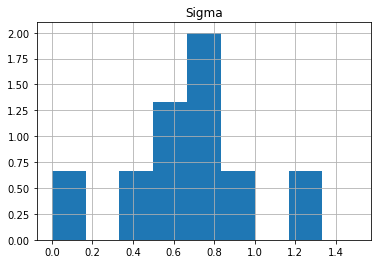

In [5]:
print info_frame.shape
#info_frame["Sigma"] = np.abs(valid_info_frame["Sigma"])
bins = np.linspace(0, 1.5, 10)
info_frame.hist("Sigma",  normed = 1, bins = bins)
print info_frame["Sigma"]
#plt.show()
plt.savefig("../../Figures/ResFigures/Res_Sigma_{0}.png".format(info_frame.shape[0]))


This is pretyy meaningless until we have more data

Average Sigma 0.647603941738763 Std in Sigma 0.30837109128414747
(9, 7)


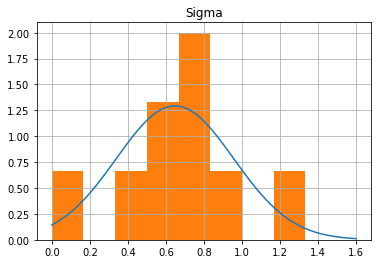

In [12]:
from scipy.stats import norm

mu_fit, sig_fit =  norm.fit(info_frame["Sigma"].values)
print "Average Sigma", mu_fit, "Std in Sigma", sig_fit
#x, xmax = plt.xlim()
fig = plt.figure()
ax = fig.add_subplot("111")
x = np.linspace(0, 1.6, 100)
p = norm.pdf(x, mu_fit, sig_fit)
plt.plot(x, p)
info_frame.hist("Sigma", normed = 1, ax = ax, bins = bins)
print info_frame.shape
#"{0} ad a {1:5f}".format(1, sig_fit)
plt.savefig("../../Figures/ResFigures/Sigma_Fit_{0}_Mean{1:5f}_Sig{2:5f}.png".format(info_frame.shape[0], mu_fit, sig_fit))


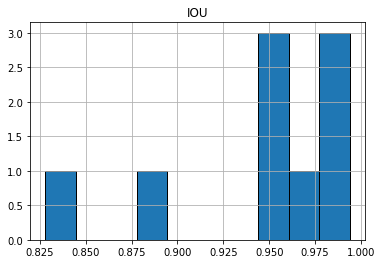

In [13]:
bins = np.linspace(0.80,1.00, 10)
#print valid_info_frame[valid_info_frame["IOU"] < 0.9]
info_frame.hist("IOU", edgecolor = "black", linewidth = 1)
#print info_frame["IOU"].min()
#info_frame.hist("IOU", edgecolor = "black", linewidth = 1, bins = bins)
plt.savefig("../../Figures/ResFigures/Res_IOU_9.png".format(info_frame.shape[0]))


In [ ]:
print valid_info_frame.shape